# Bài tập 2: Phân cụm K-Means trên dữ liệu Online Retail
Dataset: https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering

## 1. Import thư viện và load dữ liệu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load dữ liệu
df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
print("Thông tin dữ liệu:")
df.info()
print(f"\nSố dòng: {len(df)}")
print("\nMẫu dữ liệu:")
df.head()

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Số dòng: 541909

Mẫu dữ liệu:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


## 2. Làm sạch dữ liệu

In [2]:
# Kiểm tra giá trị null
print("Giá trị null:")
print(df.isnull().sum())

# Loại bỏ các dòng có CustomerID null
df = df[df['CustomerID'].notna()]

# Loại bỏ các giao dịch bị hủy (InvoiceNo bắt đầu bằng 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Loại bỏ các dòng có Quantity hoặc UnitPrice <= 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Chuyển đổi InvoiceDate sang datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

print(f"\nSố dòng sau khi làm sạch: {len(df)}")
df.head()

Giá trị null:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Số dòng sau khi làm sạch: 397884


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 3. Tạo các đặc trưng RFM (Recency, Frequency, Monetary)

In [3]:
# Tính TotalPrice cho mỗi giao dịch
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Ngày tham chiếu (ngày sau cùng + 1 ngày)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Ngày tham chiếu: {snapshot_date}")

# Tạo bảng RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("\nBảng RFM:")
print(rfm.head())
print("\nThống kê mô tả:")
print(rfm.describe())

Ngày tham chiếu: 2011-12-10 12:50:00

Bảng RFM:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40

Thống kê mô tả:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000


## 4. Khám phá phân bố dữ liệu RFM

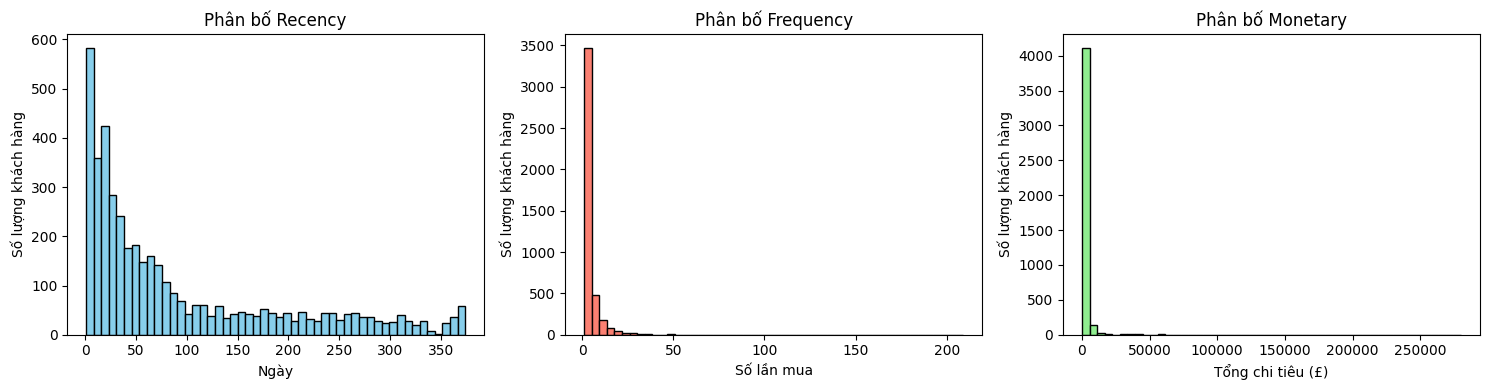

In [4]:
# Vẽ histogram cho các đặc trưng RFM
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(rfm['Recency'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Phân bố Recency')
axes[0].set_xlabel('Ngày')
axes[0].set_ylabel('Số lượng khách hàng')

axes[1].hist(rfm['Frequency'], bins=50, color='salmon', edgecolor='black')
axes[1].set_title('Phân bố Frequency')
axes[1].set_xlabel('Số lần mua')
axes[1].set_ylabel('Số lượng khách hàng')

axes[2].hist(rfm['Monetary'], bins=50, color='lightgreen', edgecolor='black')
axes[2].set_title('Phân bố Monetary')
axes[2].set_xlabel('Tổng chi tiêu (£)')
axes[2].set_ylabel('Số lượng khách hàng')

plt.tight_layout()
plt.show()

## 5. Xử lý outliers và chuẩn hóa dữ liệu

In [5]:
# Loại bỏ outliers bằng phương pháp IQR
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

rfm_clean = remove_outliers(rfm, ['Recency', 'Frequency', 'Monetary'])
print(f"Số khách hàng sau khi loại outliers: {len(rfm_clean)}")

# Chuẩn bị dữ liệu cho phân cụm
X = rfm_clean[['Recency', 'Frequency', 'Monetary']].values

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Shape của dữ liệu: {X_scaled.shape}")

Số khách hàng sau khi loại outliers: 3602
Shape của dữ liệu: (3602, 3)


## 6. Tìm số cụm tối ưu - Elbow Method

K=2, Inertia=5885.36
K=3, Inertia=3455.59
K=4, Inertia=2679.40
K=5, Inertia=2284.42
K=6, Inertia=1993.53
K=7, Inertia=1779.89
K=8, Inertia=1609.74
K=9, Inertia=1471.65
K=10, Inertia=1379.99


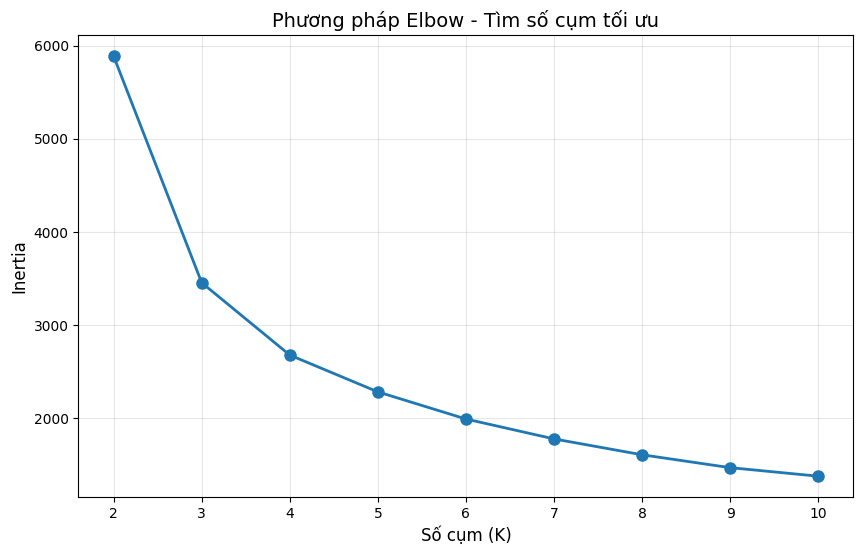

In [6]:
# Tính Inertia cho các giá trị k
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f"K={k}, Inertia={kmeans.inertia_:.2f}")

# Vẽ biểu đồ Elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('Phương pháp Elbow - Tìm số cụm tối ưu', fontsize=14)
plt.xlabel('Số cụm (K)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 7. Tìm số cụm tối ưu - Silhouette Score

K=2, Silhouette Score=0.4440
K=3, Silhouette Score=0.4530
K=4, Silhouette Score=0.4093
K=5, Silhouette Score=0.3949
K=6, Silhouette Score=0.3631
K=7, Silhouette Score=0.3533
K=8, Silhouette Score=0.3410
K=9, Silhouette Score=0.3551
K=10, Silhouette Score=0.3288


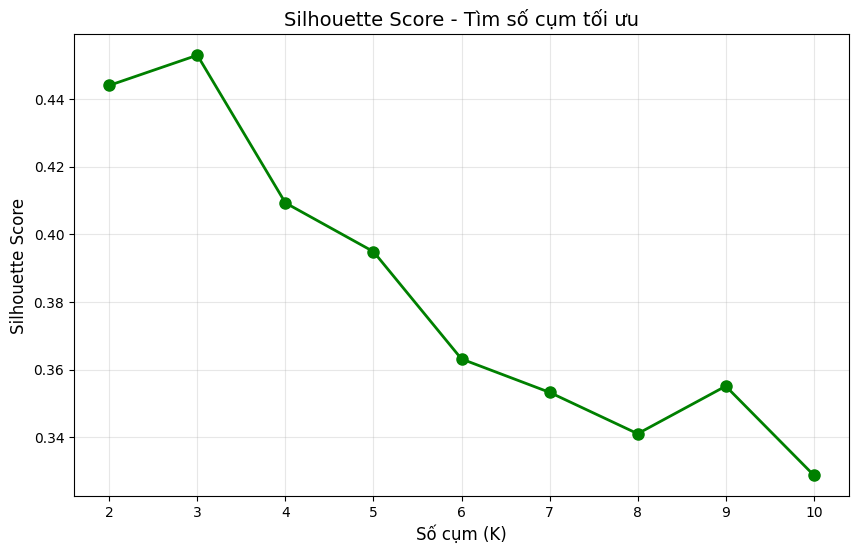


Số cụm tối ưu: K = 3


In [7]:
# Tính Silhouette Score
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

# Vẽ biểu đồ Silhouette
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', 
         linewidth=2, markersize=8, color='green')
plt.title('Silhouette Score - Tìm số cụm tối ưu', fontsize=14)
plt.xlabel('Số cụm (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nSố cụm tối ưu: K = {optimal_k}")

## 8. Xây dựng mô hình K-Means với K tối ưu

In [8]:
# Sử dụng K tối ưu (thường là 3 hoặc 4)
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Gán nhãn cụm
rfm_clean['Cluster'] = clusters

print(f"Silhouette Score: {silhouette_score(X_scaled, clusters):.4f}")
print(f"\nSố lượng khách hàng trong mỗi cụm:")
print(rfm_clean['Cluster'].value_counts().sort_index())

Silhouette Score: 0.4093

Số lượng khách hàng trong mỗi cụm:
Cluster
0    1414
1     860
2     872
3     456
Name: count, dtype: int64


## 9. Phân tích đặc điểm của các cụm


Đặc điểm trung bình của các cụm:
         Avg_Recency  Avg_Frequency  Avg_Monetary  Num_Customers
Cluster                                                         
0              52.14           1.59        407.43           1414
1              46.80           3.71       1193.21            860
2             231.01           1.48        399.63            872
3              32.09           6.74       2146.04            456


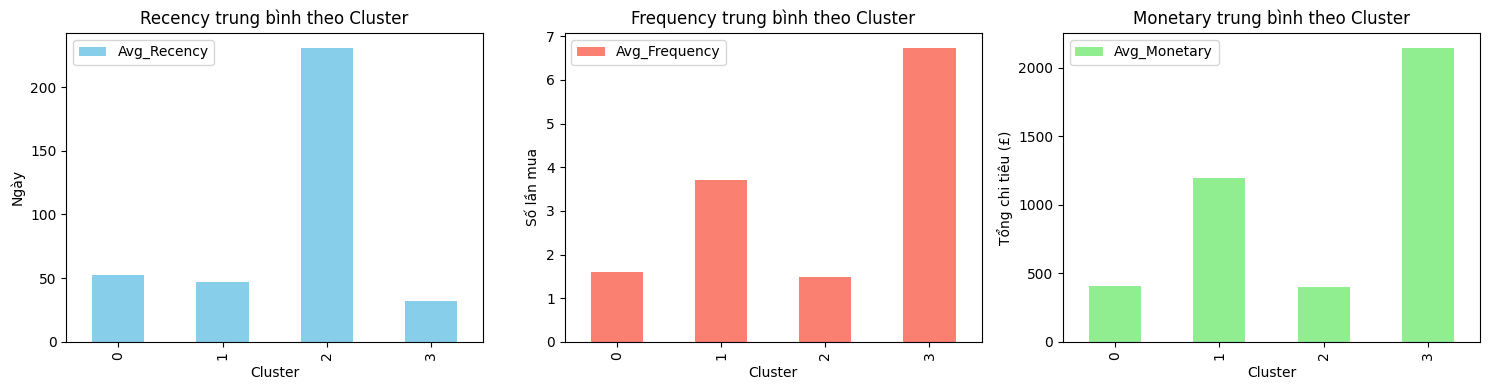

In [9]:
# Thống kê chi tiết cho từng cụm
cluster_summary = rfm_clean.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)

cluster_summary.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Num_Customers']
print("\nĐặc điểm trung bình của các cụm:")
print(cluster_summary)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cluster_summary[['Avg_Recency']].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Recency trung bình theo Cluster')
axes[0].set_ylabel('Ngày')
axes[0].set_xlabel('Cluster')

cluster_summary[['Avg_Frequency']].plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Frequency trung bình theo Cluster')
axes[1].set_ylabel('Số lần mua')
axes[1].set_xlabel('Cluster')

cluster_summary[['Avg_Monetary']].plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Monetary trung bình theo Cluster')
axes[2].set_ylabel('Tổng chi tiêu (£)')
axes[2].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

## 10. Trực quan hóa các cụm trong không gian 3D

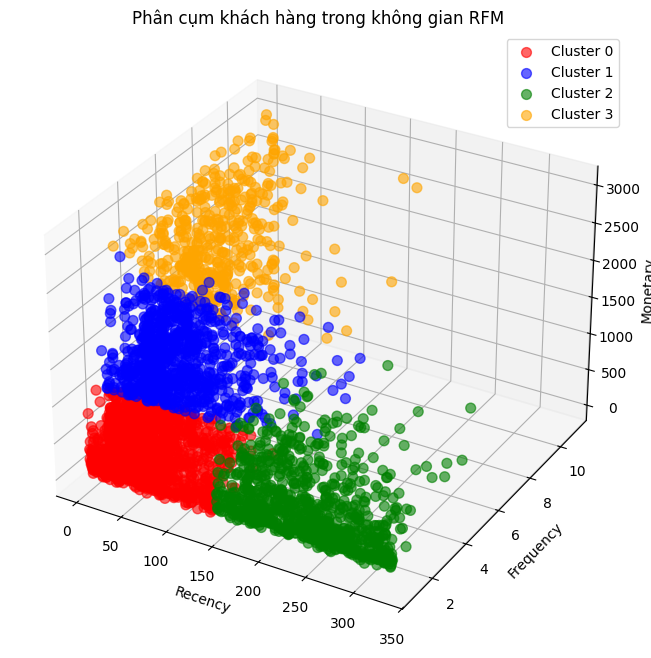

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(optimal_k):
    cluster_data = rfm_clean[rfm_clean['Cluster'] == i]
    ax.scatter(cluster_data['Recency'], 
               cluster_data['Frequency'], 
               cluster_data['Monetary'],
               c=colors[i], label=f'Cluster {i}', s=50, alpha=0.6)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Phân cụm khách hàng trong không gian RFM')
ax.legend()
plt.show()

## 11. Đặt tên cho các cụm khách hàng


Phân loại khách hàng:
Cluster  Customer_Type    
0        Regular Customers    1414
1        Regular Customers     860
2        Lost Customers        872
3        Regular Customers     456
dtype: int64


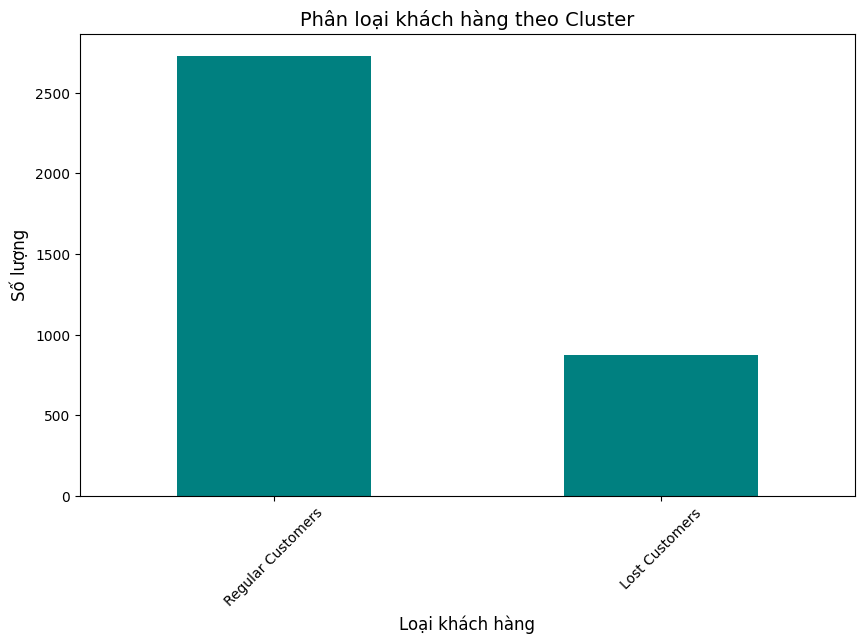

In [11]:
# Phân loại khách hàng dựa trên đặc điểm RFM
def label_cluster(row):
    """
    Gán nhãn cho cluster dựa trên giá trị RFM trung bình
    """
    cluster_avg = cluster_summary.loc[row['Cluster']]
    
    if cluster_avg['Avg_Recency'] < 50 and cluster_avg['Avg_Frequency'] > 50:
        return 'VIP Customers'
    elif cluster_avg['Avg_Monetary'] > 3000:
        return 'High Value Customers'
    elif cluster_avg['Avg_Recency'] > 100:
        return 'Lost Customers'
    else:
        return 'Regular Customers'

rfm_clean['Customer_Type'] = rfm_clean.apply(label_cluster, axis=1)

print("\nPhân loại khách hàng:")
print(rfm_clean.groupby(['Cluster', 'Customer_Type']).size())

# Visualize
plt.figure(figsize=(10, 6))
rfm_clean['Customer_Type'].value_counts().plot(kind='bar', color='teal')
plt.title('Phân loại khách hàng theo Cluster', fontsize=14)
plt.xlabel('Loại khách hàng', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.xticks(rotation=45)
plt.show()

## 12. Xuất kết quả

In [12]:
# Xuất bảng kết quả phân cụm
result = rfm_clean[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Customer_Type']]
print("\nMẫu kết quả phân cụm:")
print(result.head(10))

# Có thể xuất ra file CSV
# result.to_csv('customer_segmentation_results.csv', index=False)
# print("\nĐã xuất kết quả ra file customer_segmentation_results.csv")


Mẫu kết quả phân cụm:
    CustomerID  Recency  Frequency  Monetary  Cluster      Customer_Type
2      12348.0       75          4   1797.24        1  Regular Customers
3      12349.0       19          1   1757.55        1  Regular Customers
4      12350.0      310          1    334.40        2     Lost Customers
5      12352.0       36          8   2506.04        3  Regular Customers
6      12353.0      204          1     89.00        2     Lost Customers
7      12354.0      232          1   1079.40        2     Lost Customers
8      12355.0      214          1    459.40        2     Lost Customers
9      12356.0       23          3   2811.43        3  Regular Customers
11     12358.0        2          2   1168.06        1  Regular Customers
13     12360.0       52          3   2662.06        3  Regular Customers
